In [1]:
import hydra
from hydra.core.global_hydra import GlobalHydra
import pickle
GlobalHydra.instance().clear()

from omegaconf import DictConfig, OmegaConf
import torch
from torch.utils.data import DataLoader
from bfm_model.bfm.dataloder import LargeClimateDataset, custom_collate
from bfm_model.bfm.utils import compute_species_occurrences

In [2]:
hydra.initialize(config_path="", version_base=None)
cfg = hydra.compose(config_name="viz_config")
print(OmegaConf.to_yaml(cfg))

cfg = hydra.compose(config_name="viz_config.yaml", overrides=["data.scaling.enabled=False",
    "data.scaling.stats_path=/home/thanasis.trantas/git_projects/bfm-model/batch_statistics/statistics.json",])


model:
  T: 2
  V_surf: 2
  V_atmos: 2
  C: 3
  V_spec: 1
  V_land: 2
  V_agri: 4
  V_forest: 1
  H: 152
  W: 320
  num_latent_tokens: 8
  backbone: swin
  patch_size: 4
  embed_dim: 512
  num_heads: 16
  head_dim: 64
  depth: 2
data:
  atmos_levels:
  - 50
  - 500
  - 1000
  species_number: 22
  data_path: /home/thanasis.trantas/git_projects/bfm-model/data_small
  test_data_path: /home/thanasis.trantas/git_projects/bfm-model/data_small
  scaling:
    enabled: true
    stats_path: batch_statistics/statistics.json
    mode: normalize
training:
  batch_size: 1
  workers: 15
  epochs: 2
  accelerator: gpu
  precision: bf16-mixed
  precision_in: medium
  devices:
  - 0
  strategy: fsdp
  num_nodes: 1
  gradient_clip: 1.0
  log_steps: 1
  lr: 5.0e-05
  wd: 5.0e-07
  checkpoint_path: false
  eval_every: 2
general:
  do_eval: true
mlflow:
  port: 8082
evaluation:
  checkpoint_path: /home/thanasis.trantas/git_projects/bfm-model/outputs/2025-02-24/12-32-16/checkpoints/epoch=1-step=8.ckpt
  batc

In [3]:
dataset = LargeClimateDataset(data_dir="/home/thanasis.trantas/git_projects/bfm-model/data_small/", scaling_settings=cfg.data.scaling ,num_species=cfg.data.species_number)

stats_dataloader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=15,
    collate_fn=custom_collate,
    drop_last=True,
    shuffle=False,
)

len(stats_dataloader)

We scale the dataset False with normalize


4

In [4]:
for data in stats_dataloader:
    species_stats = compute_species_occurrences(data)
    print(species_stats)

{'Distribution': {'timestamp_t0': '2000-01-01T00:00:00', 'timestamp_t1': '2000-01-01T06:00:00', 'occurrences': {'channel_0': {'t0': 0, 't1': 0}, 'channel_1': {'t0': 1, 't1': 0}, 'channel_2': {'t0': 0, 't1': 0}, 'channel_3': {'t0': 0, 't1': 0}, 'channel_4': {'t0': 0, 't1': 0}, 'channel_5': {'t0': 0, 't1': 0}, 'channel_6': {'t0': 15, 't1': 0}, 'channel_7': {'t0': 13, 't1': 0}, 'channel_8': {'t0': 0, 't1': 0}, 'channel_9': {'t0': 2, 't1': 0}, 'channel_10': {'t0': 0, 't1': 0}, 'channel_11': {'t0': 0, 't1': 0}, 'channel_12': {'t0': 1, 't1': 0}, 'channel_13': {'t0': 1, 't1': 0}, 'channel_14': {'t0': 1, 't1': 0}, 'channel_15': {'t0': 0, 't1': 0}, 'channel_16': {'t0': 0, 't1': 0}, 'channel_17': {'t0': 1, 't1': 0}, 'channel_18': {'t0': 0, 't1': 0}, 'channel_19': {'t0': 0, 't1': 0}, 'channel_20': {'t0': 0, 't1': 0}, 'channel_21': {'t0': 25, 't1': 0}}}}
{'Distribution': {'timestamp_t0': '2000-01-01T12:00:00', 'timestamp_t1': '2000-01-01T18:00:00', 'occurrences': {'channel_0': {'t0': 0, 't1': 0}, 

{'Distribution': {'timestamp_t0': '2000-01-01T00:00:00', 'timestamp_t1': '2000-01-01T06:00:00', 'occurrences': {'t0': 0, 't1': 1}, 'difference': 1, 'pct_change': 100.0}}


/tmp/ipykernel_4116586/2218935758.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha="right")


BokehModel(combine_events=True, render_bundle={'docs_json': {'336190f8-9c28-42fe-9519-fc8849b217f5': {'version…

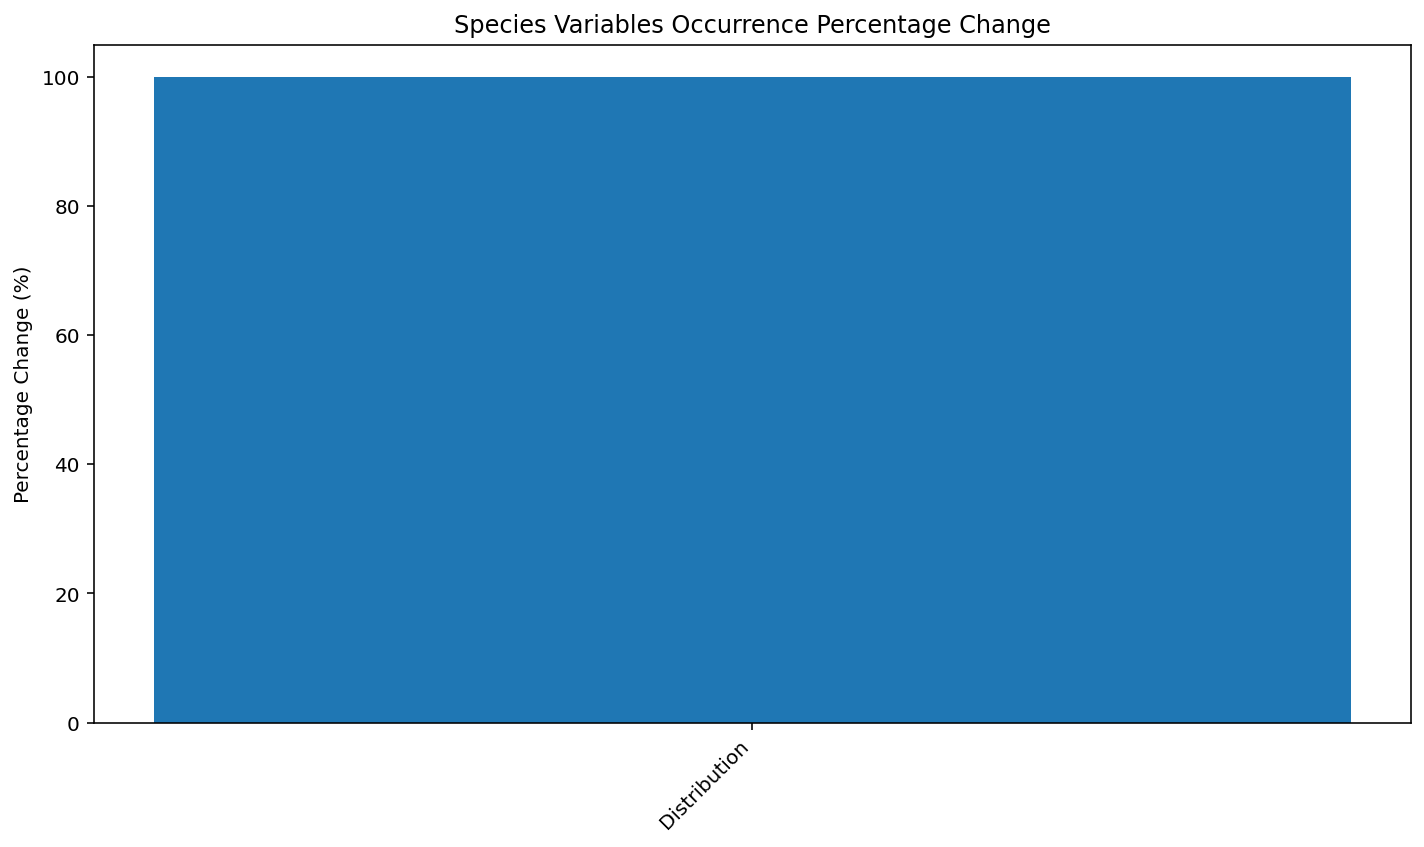

In [15]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import panel as pn
from functools import lru_cache

# Enable Panel extensions
pn.extension()

# ---------------------------------------------------------------------------------
# Helper function: load a batch from file.
# We assume each batch is saved as a .pt file (using torch.save).
@lru_cache(maxsize=1000)
def load_batch_by_index(index: int):
    # Since dataset is indexable, simply return the batch.
    return dataset[index]
# ---------------------------------------------------------------------------------
# Our existing function to compute variable statistics for a tensor.
def compute_variable_statistics(tensor: torch.Tensor) -> dict:
    stats = {}
    t = tensor.float()
    stats["min"] = float(t.min().item())
    stats["max"] = float(t.max().item())
    stats["mean"] = float(t.mean().item())
    stats["std"] = float(t.std().item())
    stats["nan_count"] = int(torch.isnan(t).sum().item())
    stats["inf_count"] = int(torch.isinf(t).sum().item())
    stats["shape"] = list(tensor.shape)
    stats["dtype"] = str(tensor.dtype)
    return stats

def compute_species_occurrences(batch) -> dict:
    """
    Compute occurrence statistics for each species variable in the batch.
    For each variable in batch.species_variables, count the number of nonzero elements
    for Timestep 1 and Timestep 2, compute the difference and percentage change.
    Timestamps are taken from batch.batch_metadata.
    
    The batch is expected to be a dictionary (or a namedtuple converted to dict) with:
        - "batch_metadata": an object or dict containing a "timestamp" field (a list of two strings)
        - "species_variables": a dict mapping variable names to tensors.
          Each tensor is either 4D: [batch, 2, lat, lon] or 5D: [batch, 2, channel, lat, lon].
    
    Returns:
        dict: A dictionary mapping variable names to computed statistics. For 4D tensors:
              { "var_name": {
                    "timestamp_t0": <timestamp>,
                    "timestamp_t1": <timestamp>,
                    "occurrences": {"t0": count_t0, "t1": count_t1},
                    "difference": diff,
                    "pct_change": pct_change
                  }, ... }
              For 5D tensors, a nested dict keyed by channel names.
    """
    result = {}
    # print(batch)
    # Convert batch to dict if necessary.
    if not isinstance(batch, dict) and hasattr(batch, "_asdict"):
        batch = batch._asdict()

    # Retrieve metadata using dictionary lookup.
    metadata = batch.get("batch_metadata", {})
    if isinstance(metadata, dict):
        timestamp_list = metadata.get("timestamp", ["unknown", "unknown"])
        pressure_levels = metadata.get("pressure_levels", None)
    else:
        # Fallback: assume attribute access.
        timestamp_list = getattr(metadata, "timestamp", ["unknown", "unknown"])
        pressure_levels = getattr(metadata, "pressure_levels", None)

    try:
        timestamp_t0 = timestamp_list[0]
        timestamp_t1 = timestamp_list[1]
    except (IndexError, TypeError):
        timestamp_t0, timestamp_t1 = "unknown", "unknown"

    species_vars = batch.get("species_variables", {})
    for var_name, tensor in species_vars.items():
        # Skip if not a tensor.
        if not isinstance(tensor, torch.Tensor):
            result[var_name] = {"note": "Not a tensor; skipping statistics."}
            continue

        # Process based on tensor dimensions.
        if tensor.ndim == 4:
            # 4D: [batch, 2, lat, lon]
            count_t0 = int(torch.count_nonzero(tensor[0, 0]).item())
            count_t1 = int(torch.count_nonzero(tensor[0, 1]).item())
            diff = count_t1 - count_t0
            pct_change = ((diff) / (count_t0 if count_t0 != 0 else 1)) * 100
            result[var_name] = {
                "timestamp_t0": timestamp_t0,
                "timestamp_t1": timestamp_t1,
                "occurrences": {"t0": count_t0, "t1": count_t1},
                "difference": diff,
                "pct_change": pct_change
            }
        elif tensor.ndim == 5:
            # 5D: [batch, 2, channel, lat, lon]
            var_result = {}
            num_channels = tensor.shape[2]
            for ch in range(num_channels):
                count_t0 = int(torch.count_nonzero(tensor[0, 0, ch]).item())
                count_t1 = int(torch.count_nonzero(tensor[0, 1, ch]).item())
                diff = count_t1 - count_t0
                pct_change = ((diff) / (count_t0 if count_t0 != 0 else 1)) * 100
                var_result[f"channel_{ch}"] = {
                    "timestamp_t0": timestamp_t0,
                    "timestamp_t1": timestamp_t1,
                    "occurrences": {"t0": count_t0, "t1": count_t1},
                    "difference": diff,
                    "pct_change": pct_change
                }
            result[var_name] = var_result
        else:
            result[var_name] = {"note": "Unsupported tensor shape for occurrence count."}

    return result


def process_species_batch(batch) -> dict:
    """
    Processes a batch from the dataset (as a dictionary) to compute species occurrence statistics.
    This function wraps compute_species_occurrences and ensures that each variable's statistics
    include an 'occurrences' key. Variables missing this key will be skipped.
    
    Returns:
        dict: Processed species statistics ready for plotting and analysis.
    """
    species_stats = compute_species_occurrences(batch)
    processed = {}
    for var_name, stats in species_stats.items():
        if "occurrences" not in stats:
            # Skip variables that don't have occurrence data.
            continue
        occ = stats["occurrences"]
        # For 4D tensors, occ is a dict with keys "t0" and "t1".
        if isinstance(occ, dict) and "t0" in occ and "t1" in occ:
            t0 = occ["t0"]
            t1 = occ["t1"]
            diff = t1 - t0
            pct_change = ((diff) / (t0 if t0 != 0 else 1)) * 100
            processed[var_name] = {
                "timestamp_t0": stats["timestamp_t0"],
                "timestamp_t1": stats["timestamp_t1"],
                "occurrences": occ,
                "difference": diff,
                "pct_change": pct_change
            }
        elif isinstance(occ, dict):
            # Assume 5D case: occ is a dict keyed by channel.
            processed[var_name] = {}
            for ch, ch_occ in occ.items():
                t0 = ch_occ["t0"]
                t1 = ch_occ["t1"]
                diff = t1 - t0
                pct_change = ((diff) / (t0 if t0 != 0 else 1)) * 100
                processed[var_name][ch] = {
                    "timestamp_t0": ch_occ.get("timestamp_t0", stats["timestamp_t0"]),
                    "timestamp_t1": ch_occ.get("timestamp_t1", stats["timestamp_t1"]),
                    "occurrences": ch_occ,
                    "difference": diff,
                    "pct_change": pct_change
                }
        else:
            processed[var_name] = {"note": "Unexpected occurrence structure."}
    return processed

# ---------------------------------------------------------------------------------
# Define a function to create a plot (for interactive GUI).
def create_species_plot(batch) -> plt.Figure:
    """
    For a given batch (from the dataset), create a matplotlib figure that shows,
    for each species variable in batch.species_variables:
      - The occurrence counts for each channel (or overall),
      - The percentage change between timesteps.
    This example creates a simple bar chart for each variable.
    """
    processed = process_species_batch(batch)
    print(processed)
    fig, ax = plt.subplots(figsize=(10, 6))
    var_names = list(processed.keys())
    if not var_names:
        ax.text(0.5, 0.5, "No species variables found", ha="center", va="center")
        return fig

    # For simplicity, plot the percentage change for each variable.
    # For 4D tensors, we expect a single percentage change per variable.
    # For 5D tensors, we plot the value for each channel.
    labels = []
    pct_values = []
    
    for var in var_names:
        stat = processed[var]
        if "pct_change" in stat:
            # 4D case
            labels.append(var)
            pct_values.append(stat["pct_change"])
        else:
            # 5D case: combine channels by listing them.
            for ch, ch_stat in stat.items():
                labels.append(f"{var}_{ch}")
                pct_values.append(ch_stat["pct_change"])
    
    ax.bar(labels, pct_values)
    ax.set_ylabel("Percentage Change (%)")
    ax.set_title("Species Variables Occurrence Percentage Change")
    ax.set_xticklabels(labels, rotation=45, ha="right")
    plt.tight_layout()
    return fig

# ------------------------------------------------------------------------------
# Build the Panel dashboard using our dataset.
# Instead of reading batch files from a folder, we use the custom dataset.
batch_indices = list(range(len(dataset)))
batch_selector = pn.widgets.DiscreteSlider(name="Select Batch Index", options=batch_indices, value=0)

@pn.depends(batch_selector)
def update_dashboard(batch_path: str):
    # Load the batch from file.
    batch = load_batch_by_index(batch_path)
    # Create the species plot.
    fig = create_species_plot(batch)
    # Also show the processed stats as text.
    processed_stats = process_species_batch(batch)
    stats_text = pn.pane.Str(object=processed_stats, width=600)
    return pn.Column(pn.pane.Matplotlib(fig, tight=True), stats_text)

dashboard = pn.Column("## Species Occurrence Dashboard", batch_selector, update_dashboard)
dashboard.servable()


Plotting species_variables:Distribution with shape torch.Size([2, 22, 152, 320])


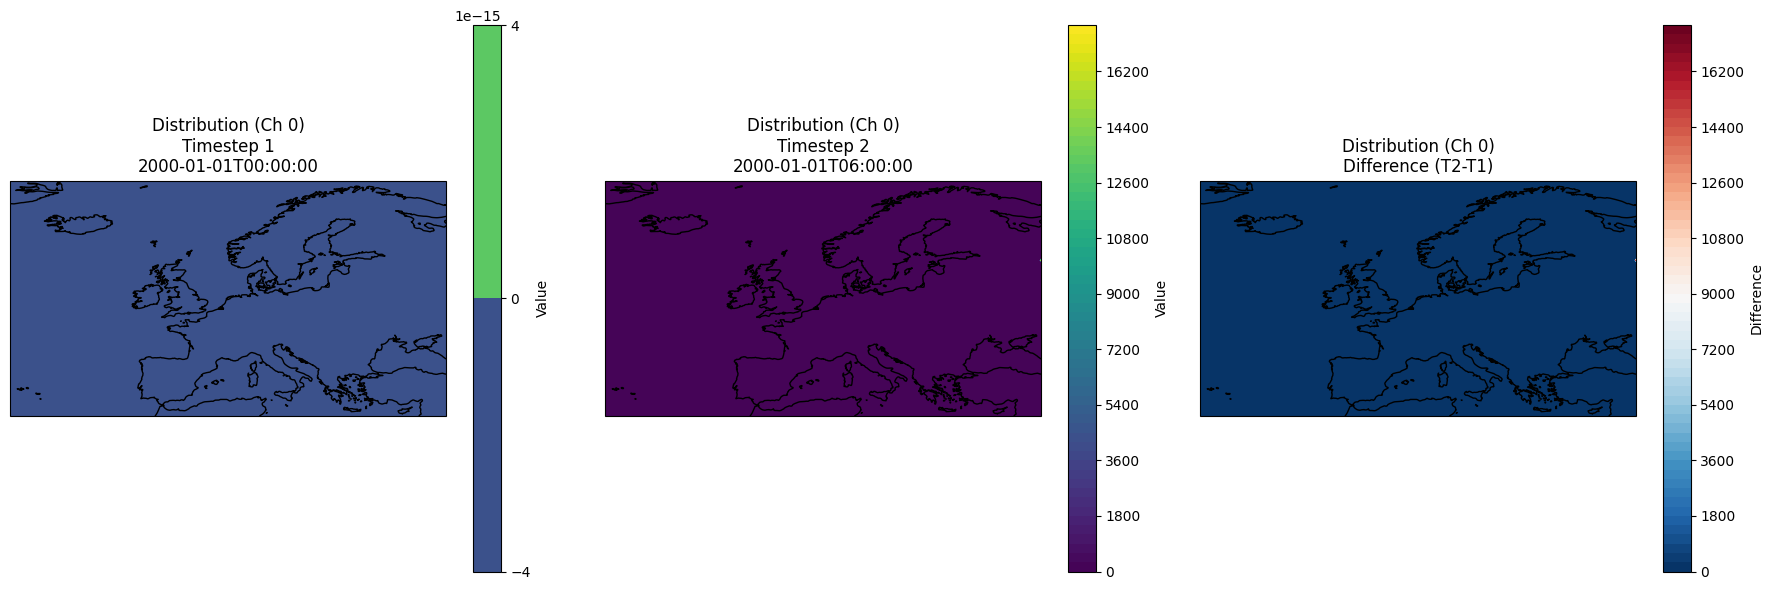

AttributeError: 'Metadata' object has no attribute 'get'

In [ ]:
from bfm_model.bfm.utils import plot_europe_timesteps_and_difference
# ------------------------------------------------------------------------------
# Compute species occurrence statistics.
def compute_species_occurrences(batch) -> dict:
    """
    For each species variable in batch["species_variables"], count the number of nonzero elements
    for Timestep 1 and Timestep 2, compute the difference and percentage change.
    Timestamps are taken from batch["batch_metadata"].
    """
    result = {}
    
    # Ensure batch is a dict.
    if not isinstance(batch, dict) and hasattr(batch, "_asdict"):
        batch = batch._asdict()
    
    metadata = batch.get("batch_metadata", {})
    timestamp_list = metadata.timestamp
    try:
        timestamp_t0 = timestamp_list[0]
        timestamp_t1 = timestamp_list[1]
    except (IndexError, TypeError):
        timestamp_t0, timestamp_t1 = "unknown", "unknown"
    
    species_vars = batch.get("species_variables", {})
    for var_name, tensor in species_vars.items():
        if not isinstance(tensor, torch.Tensor):
            result[var_name] = {"note": "Not a tensor; skipping statistics."}
            continue

        if tensor.ndim == 4:
            # 4D: [batch, 2, lat, lon]
            count_t0 = int(torch.count_nonzero(tensor[0, 0]).item())
            count_t1 = int(torch.count_nonzero(tensor[0, 1]).item())
            diff = count_t1 - count_t0
            pct_change = ((diff) / (count_t0 if count_t0 != 0 else 1)) * 100
            result[var_name] = {
                "timestamp_t0": timestamp_t0,
                "timestamp_t1": timestamp_t1,
                "occurrences": {"t0": count_t0, "t1": count_t1},
                "difference": diff,
                "pct_change": pct_change
            }
        elif tensor.ndim == 5:
            # 5D: [batch, 2, channel, lat, lon]
            var_result = {}
            num_channels = tensor.shape[2]
            for ch in range(num_channels):
                count_t0 = int(torch.count_nonzero(tensor[0, 0, ch]).item())
                count_t1 = int(torch.count_nonzero(tensor[0, 1, ch]).item())
                diff = count_t1 - count_t0
                pct_change = ((diff) / (count_t0 if count_t0 != 0 else 1)) * 100
                var_result[f"channel_{ch}"] = {
                    "timestamp_t0": timestamp_t0,
                    "timestamp_t1": timestamp_t1,
                    "occurrences": {"t0": count_t0, "t1": count_t1},
                    "difference": diff,
                    "pct_change": pct_change
                }
            result[var_name] = var_result
        else:
            result[var_name] = {"note": "Unsupported tensor shape for occurrence count."}
    return result

def process_species_batch(batch) -> dict:
    """
    Wraps compute_species_occurrences to return a processed dict suitable for plotting.
    """
    species_stats = compute_species_occurrences(batch)
    processed = {}
    for var_name, stats in species_stats.items():
        if isinstance(stats, dict) and "occurrences" in stats:
            occ = stats["occurrences"]
            t0 = occ["t0"]
            t1 = occ["t1"]
            diff = t1 - t0
            pct_change = ((diff) / (t0 if t0 != 0 else 1)) * 100
            processed[var_name] = {
                "timestamp_t0": stats["timestamp_t0"],
                "timestamp_t1": stats["timestamp_t1"],
                "occurrences": occ,
                "difference": diff,
                "pct_change": pct_change
            }
        elif isinstance(stats, dict):
            processed[var_name] = {}
            for ch, ch_stats in stats.items():
                occ = ch_stats.get("occurrences")
                if occ is None:
                    continue
                t0 = occ["t0"]
                t1 = occ["t1"]
                diff = t1 - t0
                pct_change = ((diff) / (t0 if t0 != 0 else 1)) * 100
                processed[var_name][ch] = {
                    "timestamp_t0": ch_stats.get("timestamp_t0", "unknown"),
                    "timestamp_t1": ch_stats.get("timestamp_t1", "unknown"),
                    "occurrences": occ,
                    "difference": diff,
                    "pct_change": pct_change
                }
        else:
            processed[var_name] = {"note": "Unsupported stats structure."}
    return processed

# ------------------------------------------------------------------------------
# Build the interactive dashboard with Panel using our custom dataset and DataLoader.
# Use a slider to select the batch index.
batch_indices = list(range(len(dataset)))
batch_selector = pn.widgets.DiscreteSlider(name="Select Batch Index", options=batch_indices, value=0)

groups = ["species_variables"]

@pn.depends(batch_selector)
def update_dashboard(batch_index: int):
    batch = load_batch_by_index(batch_index)
    # Create the species plot using our Europe plot function.
    # For demonstration, assume we want to plot the "Distribution" variable from species_variables.
    # Retrieve timestamps and (if needed) pressure_levels from batch metadata.
    for group_name in groups:
        true_dict = getattr(batch, group_name, {})
        for var_name, tensor in true_dict.items():
            print(f"Plotting {group_name}:{var_name} with shape {tensor.shape}")
            # Extract metadata for timestamps and pressure levels.
            metadata = batch.batch_metadata
            timestamps = metadata.timestamp
            pressure_levels = metadata.pressure_levels

            # We assume that the variable to plot is in species_variables.
            species_vars = batch.species_variables
            # Here we simply pick the first variable.
            if species_vars:
                var_name, tensor = list(species_vars.items())[0]
            else:
                var_name, tensor = "NoSpecies", None
            
            # If no valid tensor is found, display a message.
            if tensor is None:
                return pn.pane.Markdown("**No species variable data found in batch.**")
            
            # Create the plot.
            fig = plot_europe_timesteps_and_difference(var_name, tensor, timestamps,
                                                    pressure_levels=pressure_levels,
                                                    output_dir="./plots", plot=True, save=False)
            # Also show processed statistics as JSON.
            processed_stats = process_species_batch(batch)
            stats_text = pn.pane.JSON(processed_stats, width=600)
            
    return pn.Column(pn.pane.Matplotlib(fig, tight=True), stats_text)

dashboard = pn.Column("## Species Occurrence Dashboard", batch_selector, update_dashboard)
dashboard.servable()